# COVID-19 Data Analysis & Visualization
Tools:NumPy · Pandas · Matplotlib  
Dataset: Our World in Data (OWID) - `owid-covid-data.csv` (place in the same folder)  
Author: P. Shiva

Objective:Load and clean the OWID COVID-19 dataset, compute per-capita and rolling metrics, and visualize trends (cases, deaths, vaccinations) for selected countries and global aggregates.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import os

# Display settings
pd.set_option('display.max_columns', 80)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 5)


In [10]:
# Filenames / URLs
LOCAL_FULL = "owid-covid-data.csv"
URL_GITHUB = "https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv"
URL_OWID_FULL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
URL_OWID_LATEST = "https://covid.ourworldindata.org/data/latest/owid-covid-latest.csv"

def load_owid(local=LOCAL_FULL):
    # Priority: local file -> GitHub mirror -> OWID latest -> OWID full
    attempts = []
    # 1) Local
    if os.path.exists(local):
        try:
            df = pd.read_csv(local, parse_dates=['date'])
            print(f"Loaded local file: {local}")
            return df
        except Exception as e:
            attempts.append(("local", str(e)))
    # 2) GitHub mirror
    try:
        df = pd.read_csv(URL_GITHUB, parse_dates=['date'])
        print("Loaded from GitHub mirror.")
        return df
    except Exception as e:
        attempts.append(("github", str(e)))
    # 3) OWID latest
    try:
        df = pd.read_csv(URL_OWID_LATEST, parse_dates=['date'])
        print("Loaded OWID latest.")
        return df
    except Exception as e:
        attempts.append(("owid_latest", str(e)))
    # 4) OWID full
    try:
        df = pd.read_csv(URL_OWID_FULL, parse_dates=['date'])
        print("Loaded OWID full.")
        return df
    except Exception as e:
        attempts.append(("owid_full", str(e)))
    # If we reach here, print attempts and raise
    print("All loading attempts failed. Details:")
    for source, err in attempts:
        print(f"- {source}: {err}")
    raise RuntimeError("Could not load OWID dataset. Download `owid-covid-data.csv` to the notebook folder or check network.")

# Load the dataset
df = load_owid()
print("Dataset shape:", df.shape)
df.head()


Loaded from GitHub mirror.
Dataset shape: (429435, 67)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,54.42,18.6,2.58,1.34,1803.99,NaN,597.03,9.59,NaN,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,54.42,18.6,2.58,1.34,1803.99,NaN,597.03,9.59,NaN,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,54.42,18.6,2.58,1.34,1803.99,NaN,597.03,9.59,NaN,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,54.42,18.6,2.58,1.34,1803.99,NaN,597.03,9.59,NaN,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,54.42,18.6,2.58,1.34,1803.99,NaN,597.03,9.59,NaN,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN


In [14]:
# Select a compact set of relevant columns for analysis
cols = [
    'iso_code','continent','location','date',
    'total_cases','new_cases','total_deaths','new_deaths',
    'total_vaccinations','people_vaccinated','people_fully_vaccinated',
    'population'
]

# Some rows may not have all columns (dataset evolves). Use intersection.
cols_present = [c for c in cols if c in df.columns]
df = df[cols_present].copy()

print("Columns used:", cols_present)
print("Rows, cols:", df.shape)
df.info(verbose=False)
df[['location','date','total_cases','new_cases']].head(8)


Columns used: ['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'population']
Rows, cols: (429435, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429435 entries, 0 to 429434
Columns: 12 entries, iso_code to population
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 39.3+ MB


,location,date,total_cases,new_cases
0,Afghanistan,2020-01-05,0.0,0.0
1,Afghanistan,2020-01-06,0.0,0.0
2,Afghanistan,2020-01-07,0.0,0.0
3,Afghanistan,2020-01-08,0.0,0.0
4,Afghanistan,2020-01-09,0.0,0.0
5,Afghanistan,2020-01-10,0.0,0.0
6,Afghanistan,2020-01-11,0.0,0.0
7,Afghanistan,2020-01-12,0.0,0.0


In [16]:
# Cleaning steps:
# 1. Ensure population is set per country (use first non-null population)
# 2. Keep rows where location is not null
# 3. Sort by location and date

# 1. Fill population per country using 'first' available value
if 'population' in df.columns:
    df['population'] = df.groupby('iso_code')['population'].transform('first')

# 2. Drop rows missing location or date
df = df.dropna(axis=0, subset=['location','date'])

# 3. Sort
df = df.sort_values(['location','date']).reset_index(drop=True)

# Quick sanity
print("After cleaning: rows, cols =", df.shape)
df.loc[df['location']=='India'].tail(3)


After cleaning: rows, cols = (429435, 12)


,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,population
176242,IND,Asia,India,2024-08-10,NaN,NaN,NaN,NaN,2.206868e+09,1.027439e+09,951990545.0,1417173120
176243,IND,Asia,India,2024-08-11,NaN,NaN,NaN,NaN,2.206868e+09,1.027439e+09,951990547.0,1417173120
176244,IND,Asia,India,2024-08-12,NaN,NaN,NaN,NaN,2.206868e+09,1.027439e+09,951990552.0,1417173120


In [18]:
# Create derived metrics (safely handle missing population)
def safe_divide(a, b):
    return np.where((b==0) | (b.isna()), np.nan, a / b)

if 'population' in df.columns:
    df['total_cases_per_100k'] = safe_divide(df['total_cases'], df['population']) * 100000
    df['new_cases_per_100k'] = safe_divide(df['new_cases'], df['population']) * 100000
    df['total_deaths_per_100k'] = safe_divide(df['total_deaths'], df['population']) * 100000
else:
    # If population missing, create NaNs
    df['total_cases_per_100k'] = np.nan
    df['new_cases_per_100k'] = np.nan
    df['total_deaths_per_100k'] = np.nan

# Rolling averages: we'll compute on-the-fly in plotting functions (so stored series remains raw)
df.tail(2)


,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,population,total_cases_per_100k,new_cases_per_100k,total_deaths_per_100k
429433,ZWE,Africa,Zimbabwe,2024-08-03,266386.0,0.0,5740.0,0.0,NaN,NaN,NaN,16320539,1632.21325,0.0,35.170407
429434,ZWE,Africa,Zimbabwe,2024-08-04,266386.0,0.0,5740.0,0.0,NaN,NaN,NaN,16320539,1632.21325,0.0,35.170407


In [20]:
def country_series(df, country):
    s = df[df['location']==country].sort_values('date').set_index('date')
    return s

# Example
india = country_series(df, 'India')
india[['new_cases','new_cases_per_100k']].tail()


,new_cases,new_cases_per_100k
date,,
2024-08-08,NaN,NaN
2024-08-09,NaN,NaN
2024-08-10,NaN,NaN
2024-08-11,NaN,NaN
2024-08-12,NaN,NaN


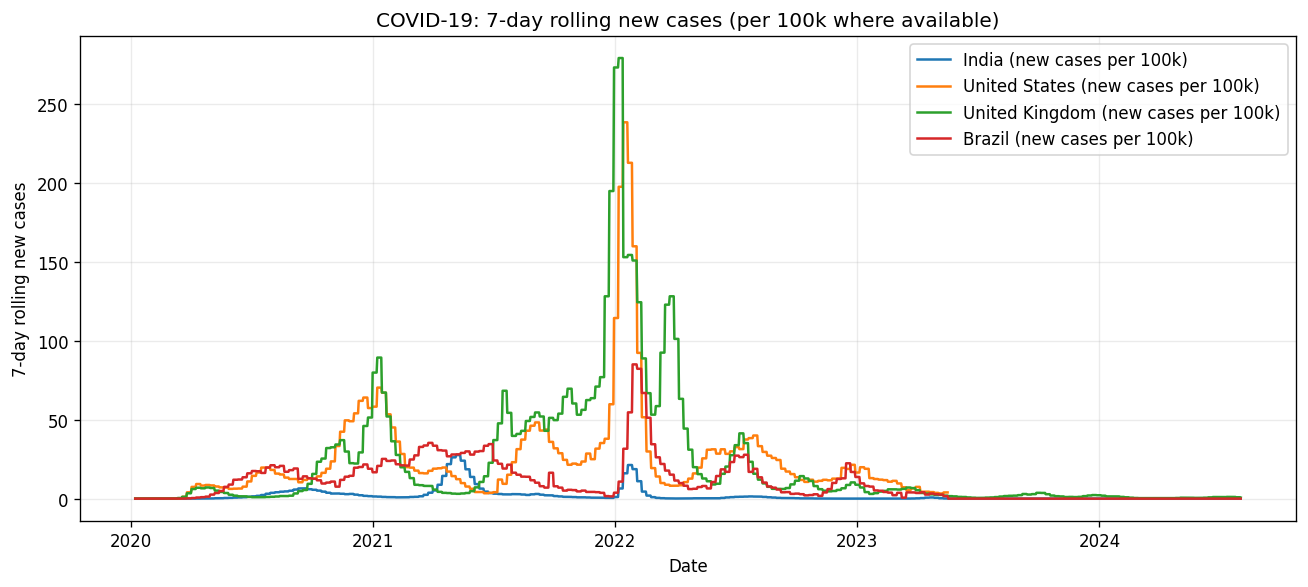

In [22]:
countries = ['India', 'United States', 'United Kingdom', 'Brazil']
plt.figure(figsize=(11,5))
for c in countries:
    s = country_series(df, c)
    if 'new_cases_per_100k' not in s.columns or s['new_cases_per_100k'].isna().all():
        # fallback to absolute new cases if per_100k not available
        series = s['new_cases'].rolling(7, center=True).mean()
        label = f"{c} (new cases)"
    else:
        series = s['new_cases_per_100k'].rolling(7, center=True).mean()
        label = f"{c} (new cases per 100k)"
    plt.plot(series.index, series.values, label=label)

plt.title('COVID-19: 7-day rolling new cases (per 100k where available)')
plt.xlabel('Date')
plt.ylabel('7-day rolling new cases')
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


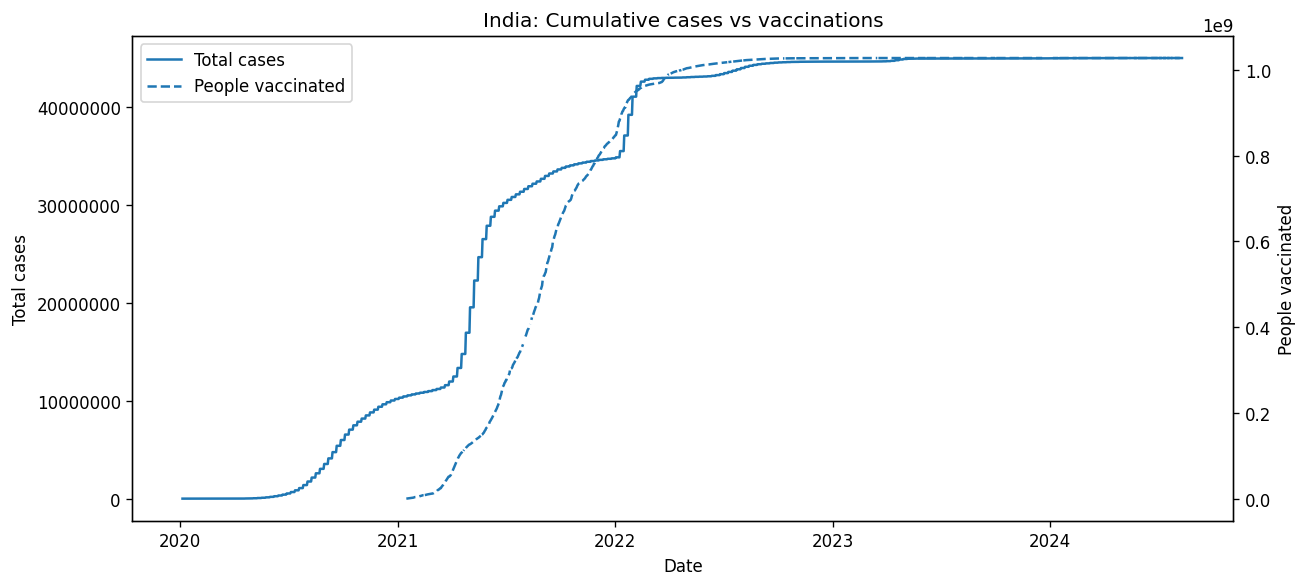

In [24]:
c = 'India'
s = country_series(df, c)

fig, ax1 = plt.subplots(figsize=(11,5))
if 'total_cases' in s.columns:
    ax1.plot(s.index, s['total_cases'], label='Total cases', linewidth=1.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Total cases', fontsize=10)
ax1.ticklabel_format(axis='y', style='plain')

ax2 = ax1.twinx()
if 'people_vaccinated' in s.columns:
    ax2.plot(s.index, s['people_vaccinated'], label='People vaccinated', linestyle='--', linewidth=1.5)
ax2.set_ylabel('People vaccinated', fontsize=10)

ax1.set_title(f'{c}: Cumulative cases vs vaccinations')
# combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')
plt.tight_layout()
plt.show()


In [26]:
# latest row per location
latest = df.sort_values('date').groupby('location').last().reset_index()

# Ensure per100k exists
if 'population' in latest.columns and 'total_cases' in latest.columns:
    latest['cases_per_100k'] = safe_divide(latest['total_cases'], latest['population']) * 100000
else:
    latest['cases_per_100k'] = np.nan

top10_cases_per_100k = latest[['location','cases_per_100k','total_cases','population']].dropna().sort_values('cases_per_100k', ascending=False).head(10)
print("Top 10 countries by cases per 100k (latest):")
top10_cases_per_100k.reset_index(drop=True)


Top 10 countries by cases per 100k (latest):


,location,cases_per_100k,total_cases,population
0,Cyprus,77723.723141,696410.0,896007
1,Brunei,77443.530318,347723.0,449002
2,San Marino,75072.721876,25292.0,33690
3,Austria,68039.201232,6082444.0,8939617
4,South Korea,66720.706160,34571873.0,51815808
5,Faroe Islands,65248.413879,34658.0,53117
6,Slovenia,63994.456193,1356582.0,2119843
7,Gibraltar,62888.270037,20550.0,32677
8,Martinique,62679.313873,230354.0,367512
9,Luxembourg,60769.208201,393542.0,647601


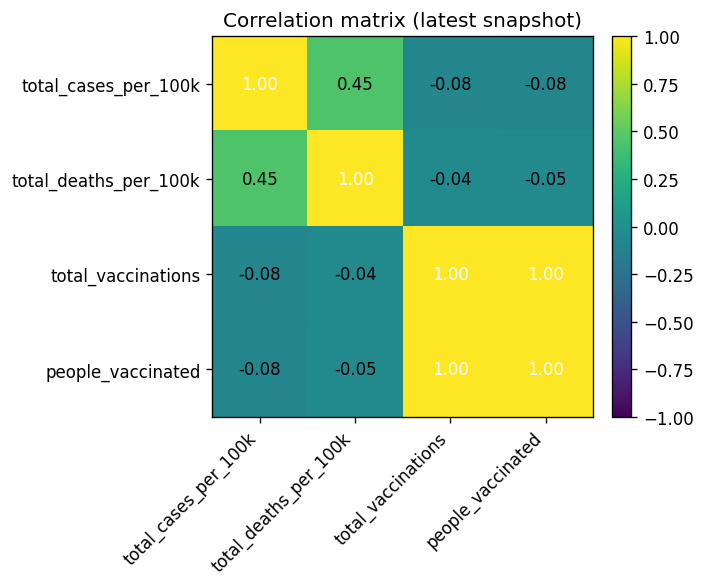

In [28]:
vars_of_interest = []
for v in ['total_cases_per_100k','total_deaths_per_100k','total_vaccinations','people_vaccinated']:
    if v in latest.columns:
        vars_of_interest.append(v)
# If derived per_100k columns missing, recompute
if 'total_cases_per_100k' not in latest.columns and 'total_cases' in latest.columns and 'population' in latest.columns:
    latest['total_cases_per_100k'] = safe_divide(latest['total_cases'], latest['population']) * 100000
    latest['total_deaths_per_100k'] = safe_divide(latest['total_deaths'], latest['population']) * 100000
    vars_of_interest = ['total_cases_per_100k','total_deaths_per_100k'] + [v for v in ['total_vaccinations','people_vaccinated'] if v in latest.columns]

if len(vars_of_interest) >= 2:
    corr = latest[vars_of_interest].corr()
    fig, ax = plt.subplots(figsize=(6,5))
    cax = ax.imshow(corr.values, vmin=-1, vmax=1)
    ax.set_xticks(np.arange(len(vars_of_interest)))
    ax.set_yticks(np.arange(len(vars_of_interest)))
    ax.set_xticklabels(vars_of_interest, rotation=45, ha='right')
    ax.set_yticklabels(vars_of_interest)
    for i in range(len(vars_of_interest)):
        for j in range(len(vars_of_interest)):
            ax.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center',
                    color='white' if abs(corr.values[i,j])>0.5 else 'black')
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    ax.set_title('Correlation matrix (latest snapshot)')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough variables available for correlation matrix. Variables found:", vars_of_interest)


Saved: figures\india_new_cases_7day.png


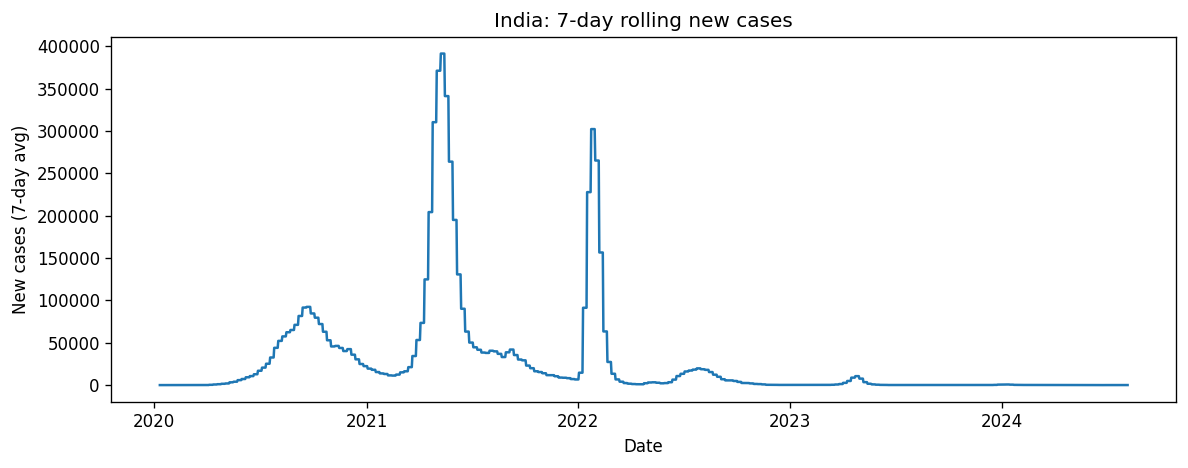

In [30]:
outdir = "figures"
os.makedirs(outdir, exist_ok=True)

# Example: save India 7-day rolling new cases (absolute)
if 'new_cases' in india.columns:
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(india.index, india['new_cases'].rolling(7).mean())
    ax.set_title('India: 7-day rolling new cases')
    ax.set_xlabel('Date')
    ax.set_ylabel('New cases (7-day avg)')
    plt.tight_layout()
    fname = os.path.join(outdir, "india_new_cases_7day.png")
    fig.savefig(fname, dpi=200)
    print("Saved:", fname)
else:
    print("No new_cases column available for India to save figure.")


## Insights & Conclusions (example)
- Visual comparison of 7-day rolling new cases reveals timing and amplitude differences across countries (different wave patterns).
- Per-100k normalization is essential to compare countries of different population sizes.
- Correlation matrix (latest snapshot) helps highlight relationships between cases, deaths and vaccination indicators (interpret carefully — correlation ≠ causation).
- Next steps: wave detection (local maxima), compute Case Fatality Rate (CFR = total_deaths / total_cases), and continent-level aggregation.


In [33]:
# Peak date (max new cases) for a country
def peak_date(df_country, col='new_cases'):
    s = df_country[col].dropna()
    if s.empty:
        return None
    idx = s.idxmax()
    return idx.date(), s.loc[idx]

print("India peak new cases date and value:", peak_date(india, 'new_cases'))

# Case Fatality Rate (CFR) by country (latest, careful with small numbers)
if 'total_deaths' in latest.columns and 'total_cases' in latest.columns:
    latest['CFR_percent'] = safe_divide(latest['total_deaths'], latest['total_cases']) * 100
    top_cfr = latest[['location','CFR_percent','total_cases']].dropna().sort_values('CFR_percent', ascending=False).head(10)
    top_cfr.reset_index(drop=True)
else:
    print("CFR cannot be computed: missing columns.")


India peak new cases date and value: (datetime.date(2021, 5, 9), 2738957.0)


In [35]:
# Save a smaller processed snapshot (latest per location) for quick reuse
processed = latest.copy()
processed.to_csv("owid_latest_snapshot.csv", index=False)
print("Saved owid_latest_snapshot.csv — smaller file for quick loading.")


Saved owid_latest_snapshot.csv — smaller file for quick loading.
